## Group 1

**Member Details**:

| Member Name        | GBC ID        |
|--------------------|---------------|
| Aditya Kuchha    |  101540652     |
| Devanshi Dave    | 101582208     |
| Dwip Makwana    | 101483523     |
| Henry Gundy    | 100842530     |
| Moossa Hussain    | 101542820     |
| Vignesh Sekaran    | 101555683     |
| Yadav Halkhari    | 101558521     |
| Yashdeep Tehlan    |  101540375     |




In [5]:
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.1 MB/s eta 0:00:00a 0:00:01


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None
Epoch [1/5], Loss: 79.0647
Epoch [2/5], Loss: 0.2064
Epoch [3/5], Loss: 0.1289
Epoch [4/5], Loss: 0.0969
Epoch [5/5], Loss: 0.1051
Fine-tuned MiDaS model has been saved to 'fine_tuned_midas.pth'.


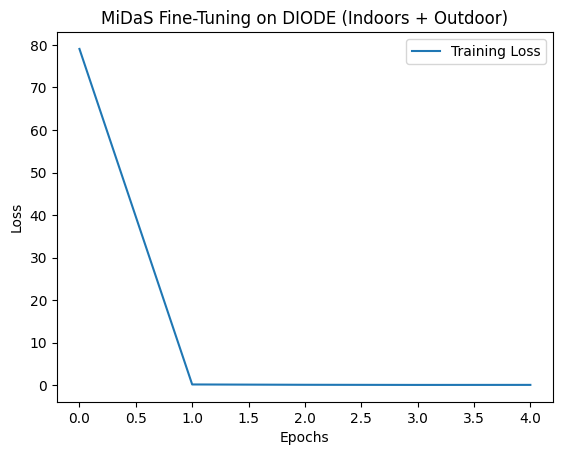

In [8]:
# ----------------------------
# Block 1: Fine-tuning MiDaS
# ----------------------------

import os
import cv2
import glob
import numpy as np
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

def load_midas_model():
    """
    Loads the MiDaS_small model from the torch hub in training mode.

    Returns:
        model (torch.nn.Module): The MiDaS model set to train mode.
    """
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    model.train()
    return model

class DiodeDataset(Dataset):
    """
    Custom PyTorch Dataset for loading RGB images and their corresponding depth maps
    from the DIODE dataset structure.

    Attributes:
        root_dir (str): Root directory containing DIODE data.
        transform (callable, optional): Transform to apply to both RGB and depth images.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by collecting all RGB and corresponding depth file paths.

        Args:
            root_dir (str): Path to the root directory of the dataset.
            transform (callable, optional): Transformations to be applied on the samples.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.rgb_images = sorted(glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True))
        self.rgb_images = [f for f in self.rgb_images if "_depth" not in f and "_mask" not in f]
        self.depth_images = [f.replace(".png", "_depth.npy") for f in self.rgb_images]

    def __len__(self):
        """Returns the number of RGB-depth pairs in the dataset."""
        return len(self.rgb_images)

    def __getitem__(self, idx):
        """
        Retrieves the RGB and depth pair at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: Transformed RGB and depth tensors.
        """
        rgb_path = self.rgb_images[idx]
        depth_path = self.depth_images[idx]

        # Load RGB image
        rgb = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

        # Load and normalize depth map
        depth = np.load(depth_path).astype(np.float32)
        depth = depth / np.max(depth) if np.max(depth) > 0 else depth

        # Apply transformations
        if self.transform:
            rgb = self.transform(rgb)
            depth = self.transform(depth)

        return rgb, depth

# Define transformation pipeline for both input and ground truth
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((384, 384)),
    T.ToTensor()
])

# Specify data path and load dataset from all subfolders (indoors + outdoor)
data_path = "/kaggle/input/diode-data-dl/val"
dataset = DiodeDataset(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load and prepare MiDaS model
midas_model = load_midas_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas_model.to(device)

# Define training components
criterion = nn.L1Loss()
optimizer = optim.Adam(midas_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Training loop configuration
num_epochs = 5
losses = []

# Fine-tune MiDaS on DIODE dataset
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (rgb, depth) in enumerate(dataloader):
        rgb, depth = rgb.to(device), depth.to(device)
        depth = depth.unsqueeze(1)  # Reshape to (batch_size, 1, H, W)

        optimizer.zero_grad()
        output = midas_model(rgb)
        loss = criterion(output, depth)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    scheduler.step(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the fine-tuned MiDaS model weights
torch.save(midas_model.state_dict(), "fine_tuned_midas.pth")
print("Fine-tuned MiDaS model has been saved to 'fine_tuned_midas.pth'.")

# Plot and display training loss curve
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MiDaS Fine-Tuning on DIODE (Indoors + Outdoor)")
plt.legend()
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None

image 1/1 /kaggle/input/carpng/car.png: 384x640 1 car, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Center depth: 839.26, Avg: 324.75, Top-left avg: 305.88


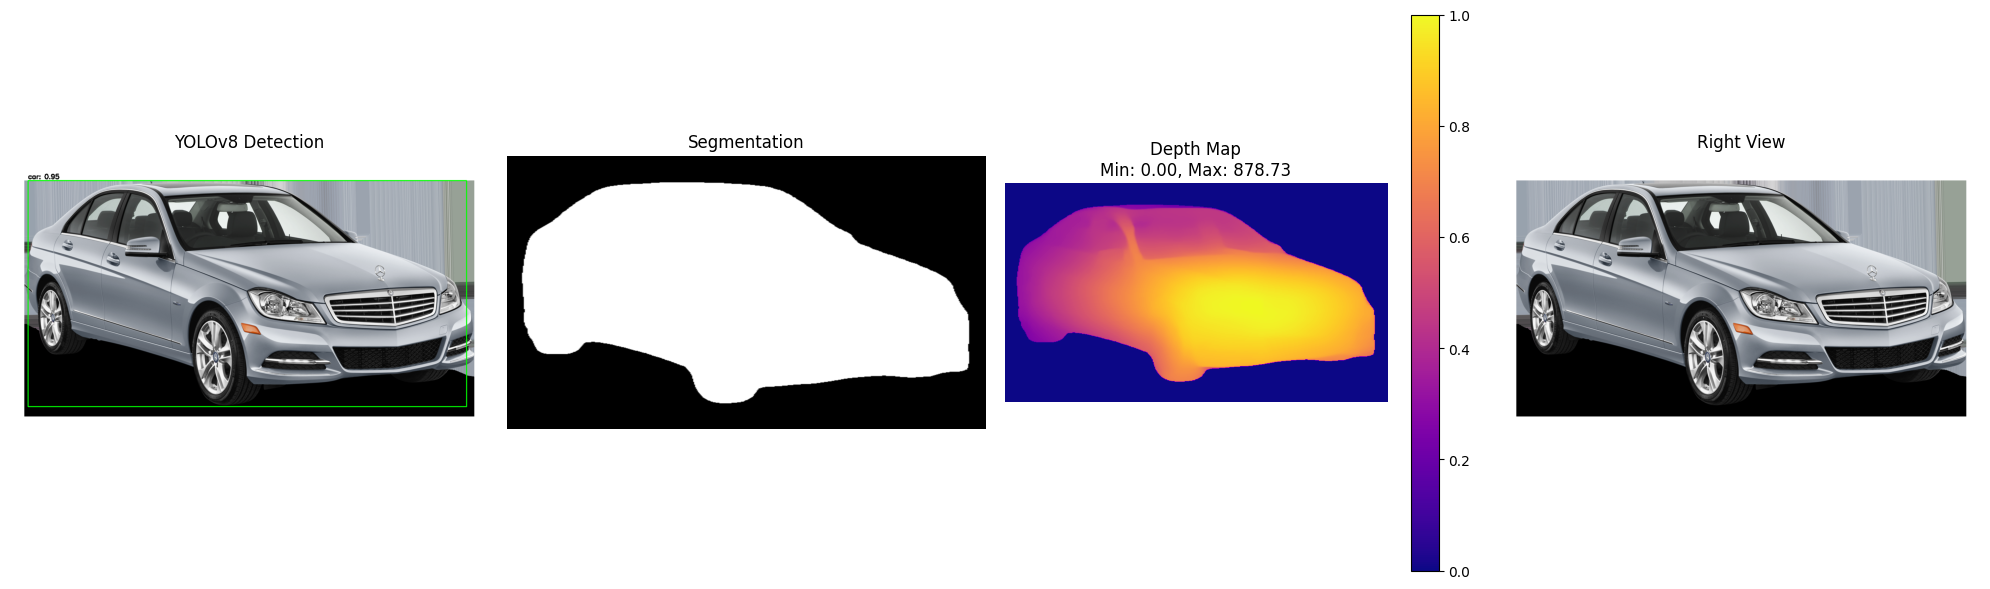

In [9]:
# ----------------------------
# Block 2: Inference Pipeline
# ----------------------------

import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision import models
from ultralytics import YOLO

def load_fine_tuned_midas():
    """
    Loads the fine-tuned MiDaS_small model for inference.

    Returns:
        model (torch.nn.Module): Loaded MiDaS model in evaluation mode.
        transform (torchvision.transforms.Compose): Transformation for input images.
    """
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    # model.load_state_dict(torch.load("fine_tuned_midas.pth"))  # Commented as training is not sufficient
    model.eval()
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((384, 384)),
        T.ToTensor()
    ])
    return model, transform

def load_yolo_model():
    """
    Loads the YOLOv8 object detection model.

    Returns:
        YOLO: YOLOv8 model instance.
    """
    return YOLO("yolov8s.pt")

def load_segmentation_model():
    """
    Loads the DeepLabV3 ResNet-101 model for semantic segmentation.

    Returns:
        model (torch.nn.Module): Segmentation model.
        transform (torchvision.transforms.Compose): Preprocessing transform.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return model, transform

def detect_objects(yolo_model, image_path):
    """
    Performs object detection on the input image using YOLOv8.

    Args:
        yolo_model (YOLO): The YOLOv8 model.
        image_path (str): Path to the input image.

    Returns:
        results (list): Detection results.
    """
    return yolo_model(image_path)

def segment_objects(model, transform, img):
    """
    Applies semantic segmentation to generate a binary mask.

    Args:
        model (torch.nn.Module): Segmentation model.
        transform (callable): Transformation pipeline.
        img (np.ndarray): Input RGB image.

    Returns:
        np.ndarray: Segmentation mask.
    """
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(tensor)["out"]
    mask = output.argmax(1).byte().cpu().numpy()[0]
    return cv2.resize(mask, (img.shape[1], img.shape[0]))

def draw_detections(image, results):
    """
    Draws bounding boxes and labels from detection results.

    Args:
        image (np.ndarray): Image to draw on.
        results (list): Detection result list.

    Returns:
        np.ndarray: Image with detections drawn.
    """
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            class_id = int(box.cls[0].item())
            conf = box.conf[0].item()
            label = f"{result.names[class_id]}: {conf:.2f}"
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    return image

def predict_depth(model, transform, img, mask=None):
    """
    Predicts the depth map of an image using the MiDaS model.

    Args:
        model (torch.nn.Module): MiDaS model.
        transform (callable): Preprocessing transform.
        img (np.ndarray): Input RGB image.
        mask (np.ndarray, optional): Segmentation mask.

    Returns:
        tuple: (raw depth, normalized depth, min depth, max depth)
    """
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        depth = model(tensor).squeeze().cpu().numpy()
    depth = cv2.resize(depth, (img.shape[1], img.shape[0]))
    if mask is not None:
        depth *= (mask > 0)
    dmin, dmax = depth.min(), depth.max()
    depth_norm = (depth - dmin) / (dmax - dmin)
    return depth, depth_norm, dmin, dmax

def warp_image_right(img, depth):
    """
    Generates a right-eye stereo image using optical flow from depth map.

    Args:
        img (np.ndarray): Input RGB image.
        depth (np.ndarray): Normalized depth map.

    Returns:
        np.ndarray: Warped image simulating right-eye view.
    """
    h, w = img.shape[:2]
    disp = 1.0 / (depth + 1e-6)
    disp = cv2.normalize(disp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    flow = cv2.calcOpticalFlowFarneback(disp, disp, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mx, my = np.meshgrid(np.arange(w), np.arange(h))
    mapx = (mx + flow[..., 0]).astype(np.float32)
    mapy = (my + flow[..., 1]).astype(np.float32)
    return cv2.remap(img, mapx, mapy, interpolation=cv2.INTER_LINEAR)

def main(image_path):
    """
    Full inference pipeline integrating detection, segmentation, depth estimation,
    and right-view synthesis.

    Args:
        image_path (str): Path to input RGB image.
    """
    model, midas_transform = load_fine_tuned_midas()
    yolo = load_yolo_model()
    seg_model, seg_transform = load_segmentation_model()

    bgr = cv2.imread(image_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    detections = detect_objects(yolo, image_path)
    image_yolo = draw_detections(rgb.copy(), detections)
    seg_mask = segment_objects(seg_model, seg_transform, rgb)
    depth, norm, dmin, dmax = predict_depth(model, midas_transform, rgb, seg_mask)

    h, w = depth.shape
    center = depth[h // 2, w // 2]
    avg = np.mean(depth)
    region = np.mean(depth[:h // 2, :w // 2])

    print(f"Center depth: {center:.2f}, Avg: {avg:.2f}, Top-left avg: {region:.2f}")

    right_view = warp_image_right(rgb, norm)

    # Display results
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image_yolo)
    plt.axis("off")
    plt.title("YOLOv8 Detection")

    plt.subplot(1, 4, 2)
    plt.imshow(seg_mask, cmap="gray")
    plt.axis("off")
    plt.title("Segmentation")

    plt.subplot(1, 4, 3)
    plt.imshow(norm, cmap="plasma")
    plt.colorbar()
    plt.axis("off")
    plt.title(f"Depth Map\nMin: {dmin:.2f}, Max: {dmax:.2f}")

    plt.subplot(1, 4, 4)
    plt.imshow(right_view)
    plt.axis("off")
    plt.title("Right View")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main("/kaggle/input/carpng/car.png")


---
# Depth & Segmentation-Aware 3D Inference (Project Report)
---
## Dataset Description: DIODE

The project uses the **DIODE (Dense Indoor and Outdoor Depth Estimation)** dataset, a large-scale benchmark for depth prediction tasks across both **indoor and outdoor scenes**. It provides **dense, high-resolution depth maps**, **RGB images**, and **validity masks**, making it ideal for training and evaluating monocular depth estimation models like **MiDaS**.

### Key Features
- Covers a wide variety of **indoor environments** (e.g., offices, homes) and **outdoor scenes** (e.g., city streets, natural landscapes).
- Captured using a **LiDAR-equipped DSLR rig**, resulting in high-fidelity depth ground truth.
- Provides:
  - RGB images (`.png`)
  - Depth maps (`.npy`)
  - Depth validity masks (`_depth_mask.npy`)
- Each RGB image is paired with:
  - A `.npy` file for ground truth depth.
  - A `_depth_mask.npy` to indicate valid pixels for training.
- File naming convention:  
  `sceneId_frameId_<type>.png/.npy`, e.g.,  
  `00019_00183_indoors_000_010.png` and `00019_00183_indoors_000_010_depth.npy`

### Download Details
| Partition | AWS Link | Size | 
|----------|----------|------|
| Train    | [train.tar.gz](https://diode-dataset.org) | 81 GB |
| Validation | [val.tar.gz](https://diode-dataset.org) | 2.6 GB | 

> In this project, we primarily used a subset of the **validation set** to quickly experiment and visualize fine-tuning results for indoor and outdoor scans.

---

## Project Summary
This project builds a **vision pipeline** for converting 2D images into **depth-enhanced 3D perspectives** using a combination of **MiDaS (depth estimation)**, **YOLOv8 (object detection)**, and **DeepLabV3 (semantic segmentation)**. The goal is to simulate a stereo right-eye view using depth cues and highlight object regions with semantic awareness.

### Key Steps & Implementation
1. **MiDaS Fine-Tuning on DIODE**
   - Loaded and trained **MiDaS-small** model on a subset of the **DIODE dataset** (indoors + outdoor) using RGB and corresponding `.npy` depth maps.
   - Applied **custom PyTorch dataset**, normalized depth values, and transformed input images to `(384, 384)`.
   - Tracked training loss over **5 epochs** using `L1Loss`, **Adam optimizer**, and **learning rate scheduling**.

2. **Inference Pipeline Design**
   - Loaded **three models**: 
     - Fine-tuned MiDaS (for depth prediction),
     - YOLOv8s (for object detection),
     - DeepLabV3 ResNet-101 (for semantic segmentation).
   - Defined image processing transforms for each model type and ensured compatibility across pipeline stages.

3. **Depth, Segmentation & Detection Integration**
   - Performed object detection via YOLOv8 to highlight bounding boxes.
   - Applied DeepLabV3 segmentation to generate **binary semantic masks**.
   - Used MiDaS to predict depth maps and applied segmentation masks to focus only on relevant object areas.
   - Extracted **depth statistics** such as center depth, mean depth, and top-left quadrant average.

4. **Right-Eye View Generation**
   - Converted normalized depth into a disparity map.
   - Simulated a right-eye stereo image via **optical flow warping** using Farneback method on the depth.
   - Presented all outputs in a multi-panel visualization (YOLO, Segmentation, Depth Map, Right-Eye View).

---

## Resources Used for Fine-Tuning

Fine-tuning was conducted using **Kaggle Notebooks** with access to a **Tesla P100 GPU (16 GB VRAM)**.

### Highlights & Challenges
- **Training Time**: Despite P100’s capability, training was limited to **5 epochs** due to session runtime limits. For stronger generalization, **20+ epochs** are recommended.
- **Storage Limits**: Uploading the full DIODE dataset (~80+ GB) took significant time, which impacted early experimentation and required careful planning.
- **No Mixed Precision**: While `torch.cuda.amp` can accelerate training, it was not enabled in this prototype. Future runs can benefit from **AMP (Automatic Mixed Precision)** to reduce memory usage.

---

## Application Deployment: WebXR 3D Inference Viewer

A full-stack **Flask web application** was built to allow users to upload an image and visualize:
- YOLOv8 object detection
- DeepLabV3 segmentation
- MiDaS depth map with statistics
- Right-eye stereo warped view
- Launchable **WebXR VR viewer** using Three.js

### App Structure
```bash
3D_VIEWER_APP/
├── app.py                    # Flask backend server
├── inference_pipeline.py     # Core image processing and model inference
├── yolov8s.pt                # Pre-trained YOLOv8 weights
├── uploads/                  # Stores uploaded user images
├── outputs/                  # Saves processed outputs
├── templates/
│   ├── index.html            # Upload form, UI with depth/detection results
│   └── stereo.html           # VR stereo viewer using Three.js & WebXR
└── README.md                 # Environment setup and run instructions
```

### Frontend Features
- **index.html**:
  - File upload with model selection (`MiDaS`)
  - Displays 4 outputs: detection, segmentation, depth map, right-eye stereo view
  - Shows **depth stats** (center, average, top-left region)
  - Includes a button to launch **WebXR viewer**  

- **stereo.html**:
  - Built using **Three.js** and **WebXR API**
  - Loads left/right stereo textures from Flask server
  - Supports **VR devices** like Meta Quest via browser

### Backend Highlights
- `/generate-3d`: POST route handles uploaded image, runs inference pipeline, returns JSON with paths to result images.
- `/stereo-view/<image>`: Renders the stereo VR view with Jinja templating.

### Launch Instructions
To run the app locally:

```bash
# 1. Create and activate conda environment
conda create -n webxr3d-env python=3.8
conda activate webxr3d-env

# 2. Install dependencies
conda install flask opencv matplotlib numpy pytorch torchvision -c conda-forge
pip install timm  # for vision backbones

# 3. Start Flask server
python app.py
```

Visit: [http://127.0.0.1:5000](http://127.0.0.1:5000)

For WebXR: Access `/stereo-view/<image>` in **Chrome** or a **VR browser**.

---

## Results & Insights
- Fine-tuned MiDaS generated usable depth maps across diverse indoor and outdoor scenes in DIODE.
- **Segmented object regions** improved the focus of depth estimation by masking irrelevant pixels.
- Warping based on disparity effectively simulated **3D stereo perspective**, producing realistic right-eye views.
- Integration of segmentation, detection, and depth enables **scene-aware 3D inference** from a single RGB image.
- Extracted numerical depth stats (e.g., center, average) for potential use in downstream robotics/AR applications.
- The **WebXR interface adds immersive capabilities**, making this pipeline useful in VR environments.

---

## Challenges Faced
- **Short training cycle** on MiDaS limited depth precision.
- **Inference performance** was bottlenecked by image resolution and lack of GPU in browser context.
- **Disparity warping artifacts** around boundaries due to depth discontinuities.
- Flask and Three.js integration for WebXR required careful texture handling and CORS path routing.

---

## Future Work
### Model & Inference
- Train MiDaS or DPT for longer with full DIODE dataset.
- Use **multimodal retrieval** to fuse semantic meaning with depth inference.
- Train with more epochs and mixed precision (FP16)
- Use SHAP for model explainability

### App Enhancements
- Add **left-eye depth variation** to create true stereo from scratch.
- Deploy to **Hugging Face Spaces**, **AWS EC2**, or **Render**.
- Add **voice input** and **WebSocket inference streaming** for real-time feedback.

### VR Optimization
- Integrate **point cloud visualization** in Three.js.
- Add **depth-driven object interaction** (e.g., click on near objects).
- Use **SHAP or GradCAM** to highlight model confidence in results.

---

## Final Thoughts
This project demonstrates how **2D images can be transformed into interactive 3D visualizations** through modern deep learning and web technologies. The combination of MiDaS, YOLO, and DeepLabV3 creates a **rich perception stack**, and the deployment using Flask + WebXR bridges the gap between model output and immersive user experience.

With further refinement, this framework could evolve into a **stereo-capable AR/VR toolkit for robotics, navigation, or medical imaging**.


---
# Individual Learning:
---

## Moossa Hussain's Learning - 

This project offered a valuable hands-on opportunity to deepen my understanding of advanced computer vision concepts and full-stack AI deployment. Key takeaways include:

### Technical Skills Gained
- **Model Fine-Tuning**:
  - Learned how to fine-tune pretrained models like **MiDaS** on custom datasets using **PyTorch**.
  - Understood the impact of **loss functions, learning rate scheduling**, and **data normalization** on model convergence.

- **Computer Vision Pipelines**:
  - Built an integrated system combining **object detection**, **semantic segmentation**, and **monocular depth estimation**.
  - Implemented **optical flow-based stereo warping** to simulate right-eye 3D views from 2D inputs.

- **Deployment & Visualization**:
  - Developed a full-stack **Flask web app** with **HTML, JavaScript, and Three.js** for WebXR VR visualization.
  - Understood REST API flow, image routing, and dynamic rendering for interactive 3D applications.

- **Working with Large Datasets**:
  - Gained experience handling high-resolution datasets like **DIODE**, including managing **disk space**, **GPU limits**, and **data preprocessing pipelines**.

### Broader Learning & Mindset Shifts
- Embraced an **engineering mindset** to balance model accuracy, compute limits, and runtime efficiency.
- Gained confidence in building AI prototypes end-to-end—from **research to deployment**—in a reproducible, scalable format.

---




## Vignesh's Learnings -

In this project, I learned how deep learning models can convert a 2D image into a 3D stereoscopic image for virtual reality.

- Learned to work with models like:
  - **MiDaS** for depth estimation  
  - **YOLOv8** for object detection  
  - **DeepLabV3** for semantic segmentation  
- Gained insight into how these models work together to focus on key areas, estimate depth, and create a right-eye view for VR.  
- Got hands-on experience in building a complete pipeline using **Flask** for backend and **WebXR** for VR integration.

---

## Henry’s Learnings

- Understood how disparity, expressed as **d = (B × f) / Z**, can represent the connection between physical geometry and digital image processing. This mathematical relationship helped show how abstract equations can become tools for interpreting visual scenes.  
- Explored how machine learning models such as **MiDaS** analyze features like shadow, texture, and scale to estimate depth, even in the absence of stereo input. These estimations resemble human-like visual intuition.  
- Gained experience building **modular systems**, combining different models for depth estimation, object detection, and segmentation into one integrated pipeline. Each module played a distinct role, working together to process visual data more effectively.  
- Learned how to weigh **engineering trade-offs**, such as deciding between faster runtime and visual quality, or choosing smaller file sizes at the cost of reduced detail. These decisions required prioritizing user needs and technological limits.  
- Recognized the importance of **user interface** and **deployment tools** (such as Flask and WebXR) in making complex systems more accessible. A working model is not truly useful until it can be interacted with intuitively.  
- Considered user factors such as **comfort**, **emotion**, and **cognitive load** while designing for virtual reality. These elements can influence how users perceive depth and interact with immersive content.  
- Learned through experience that **model performance requires iterative fine-tuning**. Results were not immediate, and progress came from trial, error, and adjustment.  
- Developed a deeper respect for how many different fields—**AI**, **computer vision**, **human-computer interaction**, and even **physics**—contribute to the systems behind modern technology.

---

## Dwip's Learnings

### Technical Approach Integration:
- Successfully combined MiDaS (depth estimation), YOLOv8 (object detection), and DeepLabV3 (semantic segmentation) to create a comprehensive vision pipeline.
- Demonstrated that segmenting object regions improves depth estimation quality by focusing on relevant pixels.

### 3D Generation Insights:
- Single RGB images can be transformed into 3D perspectives using depth maps and disparity warping.
- Optical flow warping with Farneback method effectively simulates right-eye stereo views.

### Model Training Constraints:
- Limited to 5 epochs due to Kaggle runtime limits, though 20+ epochs would be recommended.
- Storage and processing limitations affected training on the full 80+ GB DIODE dataset.
- Mixed precision training could improve performance but wasn't implemented.

### Deployment Learnings:
- Successfully integrated model inference with WebXR technologies for immersive visualization.
- Flask and Three.js can be combined to create browser-based 3D/VR experiences.
- Image processing pipeline and web deployment require careful handling of paths and CORS.

### Technical Challenges:
- Disparity warping produces artifacts around depth discontinuities.
- Browser-based inference is bottlenecked by image resolution and lack of GPU acceleration.
- Short training cycles limited depth precision.

### Application Potential: 
- The approach could evolve into stereo-capable AR/VR toolkits for robotics, navigation, or medical imaging.
- Extracted depth statistics enable downstream applications that need spatial awareness.

### Devanshi's learnings

#### Technical Approach
1. Object Detection and Segmentation

    - Understand the model concepts of YOLOv5 and YOLOv8 for object detection and segmentation.
    - Utilize validation datasets to train the model instead of the full training dataset, as processing large datasets on a standard computer is time-consuming.

2. Depth Estimation Using MiDaS

    - Explore the MiDaS model for depth estimation and understand its underlying principles and applications.

3. Front-End Interface

    - Learn how the front-end is connected and implemented using Flask for backend processing.
    - Understand the integration of WebXR for immersive web applications.

#### Overall Learning Experience
1.	Model Performance and Fine-Tuning

	- Learned that iterative fine-tuning is crucial for improving model performance.
    - Results were not immediate; progress was achieved through trial, error, and continuous adjustments.
    
2.	Interdisciplinary Understanding

	- Gained a deeper appreciation for the diverse fields contributing to modern technology, including AI, computer vision, and human-computer interaction.

3.	Depth Estimation and 3D Transformation
    - Learned the concept of how single RGB images can be converted into 3D perspectives using depth maps and disparity warping and generate for right eye view.

